<a href="https://colab.research.google.com/github/bettytan123/Sample-Size-Calculation/blob/main/Correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
############################################
## This script will simulate data from known statistical distirbutions; then estimate GAN and sample from it
## march 7 4pm hhh
## Authors: Betty and Chris

## Date: February 2023
############################################

In [ ]:
############################################
## Installations of required modules not default available on COLAB compute software stack
############################################
! pip install sdv --quiet
! pip install --upgrade scipy --quiet
!pip install sinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 KB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.7/140.7 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 KB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 KB 3.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 KB 7.7 MB/s eta 0:00:00
  Created wheel for sinfo: filename=sinfo-0.3.4-py3-none-any.whl size=7898 sha256=9ad879255ed6040ca079e6cda88e1a0a11be8680af985c7b67d4bc28482633cf
  Stored in directory: /root/.cache/pip/wheels/46/e5/1a/9110c79bf28e4f7cd88cf5fa09e0baf2b245ead095a05d61e7
Successfully built sinfo


In [ ]:

########################
## Import dependency packages
########################

## Import SDV for GANs and sampling mechanisms, etc.
from sdv.tabular import CTGAN

## Import pandas for data structures
import pandas as pd

## Import numpy for numerical computing
import numpy as np

## Import scipy for statistical distirbution function 
import scipy

## For plotting
import matplotlib.pyplot as plt

## For timing
from time import time

## Random Numbers
import random

# For progress bars
from tqdm.notebook import tqdm, trange

# Do not display warnings (bad practice)
import warnings
warnings.filterwarnings("ignore")

# For CUDA enabled/accelerated computation on the GPU 
import torch

import matplotlib.pyplot as plt
import seaborn as sns

from io import StringIO

# Import seaborn for making statistical graphics
import seaborn as sns



sns.set_style('darkgrid')

In [ ]:
## Set seed of everything
np.random.seed(614)
torch.manual_seed(614)
random.seed(614)
scipy.stats.rv_continuous.random_state = 614

In [ ]:
#####################################
##
## Sample Size for Precision of a Continuous Normal Random Variable --- by Mathemtical Theory
##
#####################################

In [ ]:
scipy.stats.norm.ppf(q=0.025, loc=0, scale=1)

-1.9599639845400545

In [ ]:
## Sample size by math

def samp_size_corr_coef(alpha, beta, correlation):
    C = 0.5 * np.log( (1+correlation)/(1-correlation) )
    n = ((scipy.stats.norm.ppf(q=alpha/2, loc=0, scale=1)+ scipy.stats.norm.ppf(q=beta, loc=0, scale=1))/C)**2 +3
    return(n)


In [ ]:
samp_size_corr_coef(alpha=0.05,beta=0.1,correlation=0.3) #113


112.67809433031636

In [ ]:
# input the mu_vector and sigma_matrix 
sigma_matrix = np.array([1,0.3,0.3,1]).reshape((2,2))
sigma_matrix

array([[1. , 0.3],
       [0.3, 1. ]])

In [ ]:
mu_vec = np.array([0,0])
mu_vec

array([0, 0])

In [ ]:
# Testing out the code working validity in the defination 
dat = scipy.stats.multivariate_normal.rvs(size=10, mean=mu_vec, cov=sigma_matrix)
dat
    

array([[-0.93665003,  0.3463049 ],
       [-0.3523312 ,  1.50869786],
       [ 0.52233849,  1.41148079],
       [-1.49011162, -1.12986384],
       [-0.41165384,  0.45622653],
       [ 0.48234941, -0.65416244],
       [-1.33211611, -1.0871453 ],
       [-0.59681424,  0.73200218],
       [-1.25909255, -0.25540589],
       [-1.07451845,  1.27923581]])

In [ ]:
res = scipy.stats.pearsonr(x=dat[:,0], y=dat[:,1], alternative='two-sided')
res

PearsonRResult(statistic=0.41848560236656773, pvalue=0.2287397023800059)

In [ ]:
# p value can be extract by 
res[1]

0.2287397023800059

In [ ]:
#################################
##
## Sample Size for Precision of a Corelation of multivariate Normal Random Variable --- by numerical simulation
##
################################

In [ ]:

def corr_ci_samp_size(n, mu_vec, sigma_matrix):
    
    ## Generate random data from multivariate normal 
    dat = scipy.stats.multivariate_normal.rvs(size=n, mean=mu_vec, cov=sigma_matrix)
    ## Analyze generated/simulated data
    res = scipy.stats.pearsonr(x=dat[:,0], y=dat[:,1], alternative='two-sided')
    ## Grab the p-value, and correlation
    pval = res[1]
    corr = res[0]
    ## Tag whether one result is stat significant or not 
    tag = np.where(pval<0.05, 1, 0)
    # Return the estimate and the CI to the user
    # this p value give you the mena p value 
    out = pd.DataFrame({'corr': [corr], 'pval': [pval], 'tag': [tag]})
    return(out)




In [ ]:
corr_ci_samp_size(n=113, mu_vec=mu_vec, sigma_matrix=sigma_matrix)

,corr,pval,tag
0,0.304032,0.001061,1


In [ ]:

## Replicate above function number of simulation replicate times to get power 

# parameter available  
n = int(np.ceil(samp_size_corr_coef(alpha=0.05,beta=0.1,correlation=0.3)))
mu_vec = np.array([0,0])
sigma_matrix = np.array([1,0.3,0.3,1]).reshape((2,2))

## Number simulation replicates
n_rep = 1000

## Simulate n_rep copies of sample size trials
sim_out = []

## Loop over number simulation replicates, storing results in list
t0 = time()

for i in trange(0, n_rep):
    sim_out.append(corr_ci_samp_size(n=n, mu_vec=mu_vec, sigma_matrix=sigma_matrix))

t1 = time()
runtime = t1 - t0

### Aggregate results into dataframe
sim_df = pd.concat(sim_out)

#Calculate power of each column in the array #axis means column power 
sim_power = np.mean(sim_df, axis=0)
sim_power

  0%|          | 0/1000 [00:00<?, ?it/s]

corr    0.295674
pval    0.024394
tag     0.901000
dtype: float64

In [ ]:
## Collect the sample size simulation results into a single dataFrame
sim_results = pd.DataFrame({
    'runtime': [runtime],
    'correlation': [sim_power[0]],
    'pvalue': [sim_power[1]],
    'power': [sim_power[2]]
})

sim_results

,runtime,correlation,pvalue,power
0,1.82703,0.295674,0.024394,0.901


In [ ]:
#############################################################
##
## Sample size estimation by GAN simulation
##
#############################################################

In [ ]:
import sys
 
path = 'logs.txt'
sys.stdout = open(path, 'w')

In [128]:
## Function to train a GAN model to simulated correlation data (with parms: pop_n, pop_mu_vec, pop_sigma_matrix)
def train_gan_model_corr(pop_n, pop_mu_vec, pop_sigma_matrix):
    ## Set seed of everything
    np.random.seed(614)
    torch.manual_seed(614)
    random.seed(614)
    scipy.stats.rv_continuous.random_state = 614

    ## Simulate data as input to GAN
    x = scipy.stats.multivariate_normal.rvs(size=pop_n, mean=pop_mu_vec, cov=pop_sigma_matrix)
    
    #   ## Convert vector to pandas dataFrame
    x_pd = pd.DataFrame(x, columns=[f'x{i}' for i in range(x.shape[1])])

    ## Feed the simulated data into SDV and sample synthetic data from the fitted GAN
    model = CTGAN(verbose=True, epochs=2000)

    ## Fit a GAN to the simulated data from above
    model.fit(x_pd)
    
    ## Return the learned model
    out = [model, x_pd]

    return out


  0%|          | 0/3 [00:00<?, ?it/s]

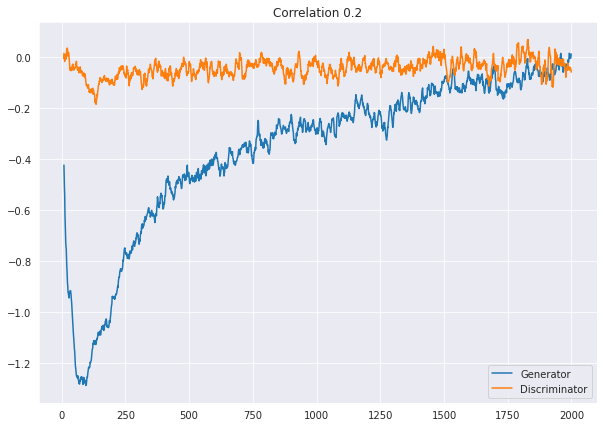

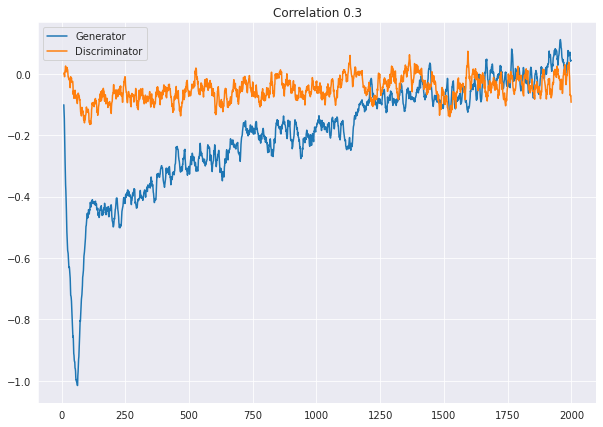

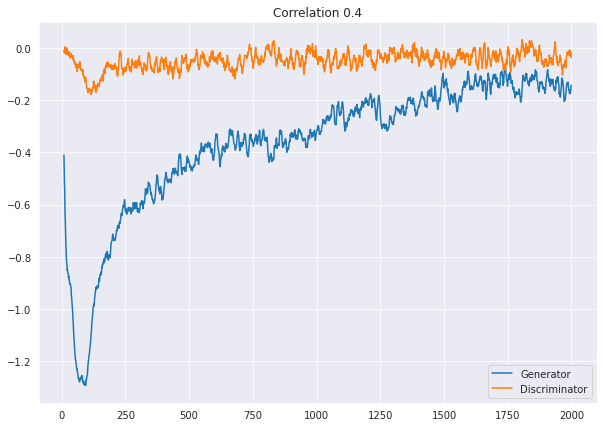

In [129]:
correlations = [0.2, 0.3, 0.4]
models = {}

for correlation in tqdm(correlations):
    path = f'logs-{correlation}.txt'
    sys.stdout = open(path, 'w')

    pop_n = 10_000
    pop_mu_vec = np.array([0.0,0.0])
    pop_sigma_matrix = np.array([1.0, correlation, correlation, 1.0]).reshape((2,2))

    ## Get the learned GAN model --- after training 
    t0 = time()
    train_gan = train_gan_model_corr(pop_n=pop_n , pop_mu_vec=pop_mu_vec, pop_sigma_matrix=pop_sigma_matrix)
    
    models[correlation] = train_gan[0]

    with open(f'logs-{correlation}.txt') as file:
        lines = file.readlines()

    output = "".join(lines)
    
    logs = StringIO(str(output))
    window = 10 # window size for the moving average, window=1 gets you the original series

    df = pd.read_csv(logs, sep=",", names=['Epochs', 'Loss G', 'Loss D'])

    # I think a regex would be better here
    df['Loss G'] = df['Loss G'].apply(lambda x: float(x.split(':')[1]))
    df['Loss D'] = df['Loss D'].apply(lambda x: float(x.split(':')[1]))

    plt.figure(figsize=(10,7))

    # Plot with a moving average so it is less noisy
    plt.plot(df['Loss G'].rolling(window=window).mean(), label="Generator")
    plt.plot(df['Loss D'].rolling(window=window).mean(), label="Discriminator")

    plt.title(f'Correlation {correlation}')

    plt.legend()
    plt.show()

In [127]:
models[0.2].sample(10)

,x0,x1
0,0.098128,-0.754785
1,-1.553380,-0.340752
2,-1.334082,-0.694900
3,-0.849661,-0.320195
4,-0.675415,-2.086499
5,-2.333504,-0.853934
6,-0.438068,-0.683319
7,-0.503747,-0.085869
8,-1.711592,-0.662391
9,-0.353013,1.246137


In [ ]:
# # %%time
# # %%capture output

# ## Parameters of binormal parent distribution
# pop_n = 50_000
# pop_mu_vec = np.array([0.0,0.0])
# pop_sigma_matrix = np.array([1.0, 0.3, 0.3, 1.0]).reshape((2,2))

# ## Get the learned GAN model --- after training 
# t0 = time()
# train_gan = train_gan_model_corr(pop_n=pop_n , pop_mu_vec=pop_mu_vec, pop_sigma_matrix=pop_sigma_matrix)
# t1 = time()
# fit_time = t1 - t0
# fit_time

# with open('logs.txt') as file:
#     lines = file.readlines()

# output = "".join(lines)
# logs = StringIO(str(output))
# window = 10 # window size for the moving average, window=1 gets you the original series

# df = pd.read_csv(logs, sep=",", names=['Epochs', 'Loss G', 'Loss D'])

# # I think a regex would be better here
# df['Loss G'] = df['Loss G'].apply(lambda x: float(x.split(':')[1]))
# df['Loss D'] = df['Loss D'].apply(lambda x: float(x.split(':')[1]))

# plt.figure(figsize=(10,7))

# # Plot with a moving average so it is less noisy
# plt.plot(df['Loss G'].rolling(window=window).mean(), label="Generator")
# plt.plot(df['Loss D'].rolling(window=window).mean(), label="Discriminator")

# plt.legend()
# plt.show()

2302.5243678092957

In [ ]:
model_ = train_gan[0]

In [ ]:
## Summarize moments of the "parent distribution" used to simulate the synthetic GAN data
x_parent = train_gan[1]

x_parent.describe()

,x0,x1
count,50000.000000,50000.000000
mean,0.000842,-0.005566
std,0.997466,1.000031
min,-5.389252,-4.172570
25%,-0.665661,-0.677765
50%,0.002842,-0.003837
75%,0.670605,0.670629
max,4.325305,3.836361


In [ ]:
## Parameter for specifying size of the simulated/synthetic data generated from the GAN
sim_n = int(np.ceil(samp_size_corr_coef(alpha=0.05,beta=0.1,correlation=0.3)))
sim_n

113

In [ ]:
## Function to analyze data from the sampled model 
def corr_power_samp_size_gan(m, sim_n):
    ## Generate random data --- sampling from the trained GAN which approximates the normal probability generating function
    dat = m.sample(num_rows=sim_n).values
    ## Analyze generated/simulated data
    res = scipy.stats.pearsonr(x=dat[:,0], y=dat[:,1], alternative='two-sided')
    
    ## Extract the estimate and CI
    pval = res[1]
    corr = res[0]
    tag = np.where(pval<0.05, 1, 0)
   
    # Return the estimate and the CI to the user
    out = pd.DataFrame({'corr': [corr], 'pval': [pval], 'tag': [tag]})
    return(out)


In [ ]:
## Replicate above function number of simulation replicate times

## Number simulation replicates
n_rep = 1000

## Simulate n_rep copies of sample size trials
gan_out = []

## Loop over number simulation replicates, storing results in list
t0 = time()

for i in trange(0, n_rep):
    gan_out.append(corr_power_samp_size_gan(m=model_, sim_n=sim_n))

t1 = time()
runtime = t1 - t0

## Aggregate results into dataframe
gan_df = pd.concat(gan_out)

## Calculate means of each column in the array #axis means column mean 
gan_power = np.mean(gan_df, axis=0)



  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
gan_power

corr    0.277701
pval    0.033275
tag     0.854000
dtype: float64

In [ ]:
## Collect results of the GAN based sample size calculations
gan_results = pd.DataFrame({
    'runtime': [runtime],
    'correlation': [gan_power[0]],
    'pvalue': [gan_power[1]],
    'power': [gan_power[2]]
})

gan_results



,runtime,correlation,pvalue,power
0,18.644672,0.277701,0.033275,0.854


In [ ]:
#########################################################################
##
##
## Below we investgiate finite sample properties of three methods for estimating sample size for a continuous CI from normal distribution
##    1) Theory or analytic formula
##    2) Simulation (from normal probability generating model)
##    3) Simulation (from GAN approximating parent normal probability generating model)
##
##
#########################################################################

In [ ]:
###########################
## Create parameter grid
###########################
from itertools import product

def expand_grid(dictionary):
   return pd.DataFrame([row for row in product(*dictionary.values())], columns=dictionary.keys())

dictionary = {'alpha': [0.05], 
              'corr': np.arange(0.2, 0.5, 0.1), 
              'beta': [0.05, 0.1, 0.2, 0.3]}

param_df = expand_grid(dictionary)
param_df

,alpha,corr,beta
0,0.05,0.1,0.05
1,0.05,0.1,0.10
2,0.05,0.1,0.20
3,0.05,0.1,0.30
4,0.05,0.2,0.05
5,0.05,0.2,0.10
6,0.05,0.2,0.20
7,0.05,0.2,0.30
8,0.05,0.3,0.05
9,0.05,0.3,0.10


In [ ]:
#################
## 1) Sample Size for Continuous CI by Theory or Analytic Formula
#################
samp_size_theory_list = []

for i in np.arange(param_df.shape[0]):
    ## Compute sample size at particular parameter condiguration
    n = samp_size_corr_coef(alpha=param_df.loc[i, 'alpha'], 
                          correlation=param_df.loc[i, 'corr'],
                          beta=param_df.loc[i, 'beta'])
    ## Round to largest integer
    n_ = str(np.round(np.ceil(n),0))
    ## Append sample size to list
    samp_size_theory_list.append(n_)

samp_size_theory_df = pd.concat([param_df, pd.Series(samp_size_theory_list)], axis=1)
samp_size_theory_df.columns = ['alpha','corr','beta','n_theory']
samp_size_theory_df

,alpha,corr,beta,n_theory
0,0.05,0.1,0.05,1294.0
1,0.05,0.1,0.10,1047.0
2,0.05,0.1,0.20,783.0
3,0.05,0.1,0.30,617.0
4,0.05,0.2,0.05,320.0
5,0.05,0.2,0.10,259.0
6,0.05,0.2,0.20,194.0
7,0.05,0.2,0.30,154.0
8,0.05,0.3,0.05,139.0
9,0.05,0.3,0.10,113.0


In [ ]:
########################
## 2) Sample Size for Power by Simulation from multivariate Distribution
########################

In [ ]:
def corr_power_samp_size(corr, n):
    
    ## Generate random data
    sigma_matrix = np.array([1,corr,corr,1]).reshape((2,2))
    mu_vec = np.array([0,0])
    dat = scipy.stats.multivariate_normal.rvs(size=n, mean=mu_vec, cov=sigma_matrix)
    ## Analyze generated/simulated data
  
    res = scipy.stats.pearsonr(x=dat[:,0], y=dat[:,1], alternative='two-sided')

    ## Extract the estimate and CI
    pval = res[1]
    corr = res[0]
    tag = np.where(pval<0.05, 1, 0)
    
    # Return the estimate and the CI to the user
    # [] make it a list instead of scalar
    out = pd.DataFrame({'corr': [corr], 
                        'pval': [pval], 
                        'tag': [tag]})
    return(out)


In [ ]:
corr_power_samp_size(corr=0.3, n=113)

,corr,pval,tag
0,0.358674,0.000096,1


In [ ]:
##
## Replicate above function to compute expected CI width, for continuous mean, at various parm values (mu, std, n) over number sim replicated (n_rep)
##
def corr_power_samp_size_sim( corr, n, n_rep):

    ## Simulate n_rep copies of sample size trials
    sim_out = []

    ## Loop over number simulation replicates, storing results in list
    t0 = time()

    for i in trange(0, n_rep):
        sim_out.append(corr_power_samp_size(corr=corr, n=n))

    t1 = time()
    runtime = t1 - t0

    ### Aggregate results into dataframe
    sim_df = pd.concat(sim_out)

    ## Calculate means of each column in the array 
    sim_power = np.mean(sim_df, axis=0)

    ## Return expect width 
    sim_result = pd.DataFrame({
    'runtime': [runtime],
    'correlation': [sim_power[0]],
    'pvalue': [sim_power[1]],
    'power': [sim_power[2]]
})

    return sim_result


In [ ]:
corr_power_samp_size_sim( corr=0.3, n=113,n_rep= 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

,runtime,correlation,pvalue,power
0,2.113688,0.296969,0.019771,0.901


In [ ]:
## Loop over theoretical table, to use simulation to understand relationship between (n, corr n_rep) etc.
samp_size_sim_list = []

## 1000 simulation replicates; reduces computational burden
n_rep = 1000

t0 = time()

for i in np.arange(samp_size_theory_df.shape[0]):
    ## Compute sample size at particular parameter condiguration
    power_value = corr_power_samp_size_sim(n=int(float(samp_size_theory_df.loc[i, 'n_theory'])), 
                          corr= samp_size_theory_df.loc[i, 'corr'],
                          n_rep=n_rep)
    ## Round to largest integer
    #value 0 give you elment change from data frame to numebr 
    power_value_ = power_value['power'].values[0]
    #power_width_ = power_width.tag
    ## Append sample size to list
    samp_size_sim_list.append(power_value_)

t1 = time()
sim_time = t1-t0

## Compile results into dataFrame
samp_size_sim_df = pd.concat([samp_size_theory_df, pd.Series(samp_size_sim_list)], axis=1)
samp_size_sim_df.columns = ['alpha','corr','beta','n_theory','power_width_sim']
samp_size_sim_df

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

,alpha,corr,beta,n_theory,power_width_sim
0,0.05,0.1,0.05,1294.0,0.947
1,0.05,0.1,0.10,1047.0,0.906
2,0.05,0.1,0.20,783.0,0.796
3,0.05,0.1,0.30,617.0,0.709
4,0.05,0.2,0.05,320.0,0.956
5,0.05,0.2,0.10,259.0,0.898
6,0.05,0.2,0.20,194.0,0.806
7,0.05,0.2,0.30,154.0,0.732
8,0.05,0.3,0.05,139.0,0.952
9,0.05,0.3,0.10,113.0,0.907


In [ ]:
## Timing for the simulation experiments
sim_time

28.031673669815063

In [ ]:
########################
## 3) Sample Size for Continuous CI by Generative Adversarial Network (GAN) from a (parent) Normal Distribution
########################

In [ ]:
# ## Function to train a GAN model to simulated normal data (with parms: mean, sd, n)
# def train_gan_model_corr(pop_n, pop_mu_vec, pop_sigma_matrix):
#     ## Set seed of everything
#     np.random.seed(614)
#     torch.manual_seed(614)
#     random.seed(614)
#     scipy.stats.rv_continuous.random_state = 614

#     ## Simulate data as input to GAN
#     x = scipy.stats.multivariate_normal.rvs(size=pop_n , mean=pop_mu_vec, cov=pop_sigma_matrix)
#     ##
#     #   ## Convert vector to pandas dataFrame
#     # x_pd = pd.DataFrame({'x': x}) #need two column array 
#     x_pd = pd.DataFrame(x, columns=['x0', 'x1'])

#     ## Feed the simulated data into SDV and sample synthetic data from the fitted GAN
#     model = CTGAN(verbose=False, epochs=2000)

#     ## Fit a GAN to the simulated data from above
#     model.fit(x_pd)
    
#     ## Return the learned model
#     out = [model, x_pd]

#     return out




In [130]:
## Function to analyze data from the sampled model 
def corr_power_samp_size_gan(model, sim_n):
    ## Generate random data --- sampling from the trained GAN which approximates the normal probability generating function
    dat = model.sample(num_rows=sim_n).values
    ## Analyze generated/simulated data
    res = scipy.stats.pearsonr(x=dat[:,0], y=dat[:,1], alternative='two-sided')
    
    ## Extract the estimate and CI
    pval = res[1]
    r = res[0]
    tag = np.where(pval<0.05, 1, 0)
   
    # Return the estimate and the CI to the user
    out = pd.DataFrame({'r': [r], 'pval': [pval], 'tag': [tag]})
    return(out)

In [132]:
##
## Replicate above function to compute expected CI width, for continuous mean, at various parm values (mu, std, n) over number sim replicated (n_rep)
##
def corr_power_samp_size_gan_sim(model, sim_n, n_rep):
    ##
    ## Replicate above function number of simulation replicate times
    ##

    ## Simulate n_rep copies of sample size trials
    gan_out = []
 
    ## Loop over number simulation replicates, storing results in list
    t0 = time()

    for i in trange(0, n_rep):
        gan_out.append(corr_power_samp_size_gan(model, sim_n = sim_n))

    t1 = time()
    gan_time = t1 - t0

    ## Aggregate results into dataframe
    gan_df = pd.concat(gan_out)

    ## Calculate means of each column in the array #axis means column mean 
    gan_power = np.mean(gan_df, axis=0)

    ## Return the GAN estimated power

    ## Return expect width 
    gan_result = pd.DataFrame({
        'runtime': [runtime],
        'correlation': [gan_power[0]],
        'pvalue': [gan_power[1]],
        'power': [gan_power[2]]
    })

    return gan_result


In [141]:
##
## WARNING...notice very subtle difference between pop_n and sim_n
##
## "sim_n" should be set to size of theoretical sample size needed to obtain CI of expected width, given SD/alpha/mean
##
## "pop_n" can vary...larger values mean GAN parent dist is more likely converge in dist to population model, smaller values reduce likelihood convergence in dist
##     --- larger values can also substantially increase training time for the GAN model
##

# t0 = time()
# pop_n=1000
# tmp = corr_power_samp_size_gan(pop_n= pop_n, 
#                                pop_mu_vec= np.array([0,0]),
#                                pop_sigma_matrix = np.array([1,0.3,0.3,1]).reshape((2,2)),
#                                sim_n=int(np.ceil(samp_size_corr_coef(alpha=0.05,beta=0.1,correlation=0.3))),
#                                n_rep=1000)


# t1 = time()

# [tmp, t1-t0]

In [143]:
models

{0.2: <sdv.tabular.ctgan.CTGAN at 0x7f0739756a90>,
 0.3: <sdv.tabular.ctgan.CTGAN at 0x7f07392a8220>,
 0.4: <sdv.tabular.ctgan.CTGAN at 0x7f0738b46cd0>}

In [151]:
## Loop over theoretical table, to use simulation to understand relationship between (n, mu, std, n_rep) etc.
samp_size_gan_list = []

## 1000 simulation replicates; reduces computational burden
n_rep = 1000

t0 = time()

for i in np.arange(samp_size_theory_df.shape[0]):
    ## Compute sample size at particular parameter condiguration
    correlation = np.float(samp_size_theory_df.loc[i, 'corr'])

    if correlation in models:
        model = models[correlation]

        power_value = corr_power_samp_size_gan_sim(
            model,
            sim_n=int(float(samp_size_theory_df.loc[i, 'n_theory'])),
            n_rep=n_rep
        )
           
        #value 0 give you elment change from data frame to numebr 
        power_value_ = power_value['power'].values[0]
        #power_width_ = power_width.tag
        ## Append sample size to list
        samp_size_gan_list.append(power_value_)
        ## Round to largest integer

    else:
      samp_size_gan_list.append(np.nan)
  

t1 = time()
gan_time = t1-t0

## Compile results into dataFrame
samp_size_gan_df = pd.concat([samp_size_theory_df, pd.Series(samp_size_gan_list)], axis=1)
samp_size_gan_df.columns = ['alpha','corr','beta','n_theory','power_width_gan']
samp_size_gan_df

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

,alpha,corr,beta,n_theory,power_width_gan
0,0.05,0.1,0.05,1294.0,NaN
1,0.05,0.1,0.10,1047.0,NaN
2,0.05,0.1,0.20,783.0,NaN
3,0.05,0.1,0.30,617.0,NaN
4,0.05,0.2,0.05,320.0,0.936
5,0.05,0.2,0.10,259.0,0.867
6,0.05,0.2,0.20,194.0,0.785
7,0.05,0.2,0.30,154.0,0.717
8,0.05,0.3,0.05,139.0,NaN
9,0.05,0.3,0.10,113.0,NaN


In [146]:
models

{0.2: <sdv.tabular.ctgan.CTGAN at 0x7f0739756a90>,
 0.3: <sdv.tabular.ctgan.CTGAN at 0x7f07392a8220>,
 0.4: <sdv.tabular.ctgan.CTGAN at 0x7f0738b46cd0>}

In [134]:
#gan_time

In [135]:
##############################################
##
## Properties/info on the Jupyter Notebook session
##
#############################################

In [136]:
## Date/time
from datetime import datetime
str(datetime.today()).split()[0]

'2023-03-23'

In [137]:
## Session Info
from sinfo import sinfo
sinfo()

In [138]:
## Jupyter version
!jupyter --version

In [139]:
## Python version
!python --version

# Plot simulated data vs real 

In [140]:
#https://subscription.packtpub.com/book/big-data-and-business-intelligence/9781784390150/4/ch04lvl1sec41/trellis-plots
#How to put things side by side 
data = train_gan[0]
plt.figure()
plot = rplot.RPlot(data, x='x1', y='x2')
plot.add(rplot.TrellisGrid(['x1', 'x2']))
plot.add(rplot.GeomHistogram())
plot.render(plt.gcf())

NameError: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
train_gan[1]

In [ ]:
train_gan[1].corr()

In [ ]:
#heatmap plots 
sns.heatmap(train_gan[1].corr().values)

# n=10000
# sigma_matrix = np.array([1,0.3,0.3,1]).reshape((2,2))
# mu_vec = np.array([0,0])
# dat = scipy.stats.multivariate_normal.rvs(size=n, mean=mu_vec, cov=sigma_matrix)
# sns.heatmap(dat)

plt.show()

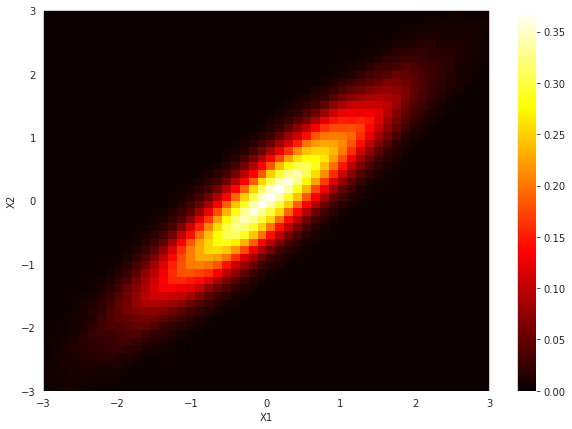

In [152]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kde

pop_n = 50_000
pop_mu_vec = np.array([0,0])
pop_sigma_matrix = np.array([[1.0 , 0.9], [0.9, 1.0]])

# load the dataset
# geyser = np.loadtxt("geyser.csv", delimiter=",", skiprows=1)
geyser = scipy.stats.multivariate_normal.rvs(size=pop_n, mean=pop_mu_vec, cov=pop_sigma_matrix)

# extract the columns
duration = geyser[:,0]
waiting = geyser[:,1]

# create a scatter plot
# plt.scatter(duration, waiting)
# plt.xlim(0.5, 6)
# plt.ylim(40, 100)

# create a 2D kernel density estimate
xmin, xmax, ymin, ymax = -3, 3, -3, 3
X, Y = np.mgrid[xmin:xmax:50j, ymin:ymax:50j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([duration, waiting])
kernel = kde.gaussian_kde(values)
f1 = np.reshape(kernel(positions).T, X.shape)

# create an image plot of the density estimate
plt.figure(figsize=(10,7))

plt.imshow(f1, origin='lower', extent=[xmin, xmax, ymin, ymax], aspect='auto', cmap='hot')
plt.colorbar()
plt.grid(None)

plt.xlabel('X1')
plt.ylabel('X2')

plt.show()

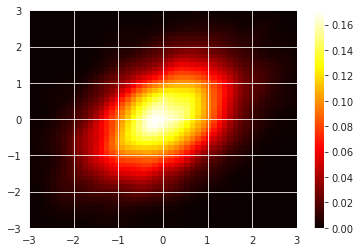

In [153]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kde

# load the dataset
# geyser = np.loadtxt("geyser.csv", delimiter=",", skiprows=1)
geyser = train_gan[1].values

# extract the columns
duration = geyser[:,0]
waiting = geyser[:,1]

# create a scatter plot
# plt.scatter(duration, waiting)
# plt.xlim(0.5, 6)
# plt.ylim(40, 100)

# create a 2D kernel density estimate
xmin, xmax, ymin, ymax = -3, 3, -3, 3
X, Y = np.mgrid[xmin:xmax:50j, ymin:ymax:50j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([duration, waiting])
kernel = kde.gaussian_kde(values)
f1 = np.reshape(kernel(positions).T, X.shape)

# create an image plot of the density estimate
plt.imshow(f1, origin='lower', extent=[xmin, xmax, ymin, ymax], aspect='auto', cmap='hot')
plt.colorbar()
plt.show()

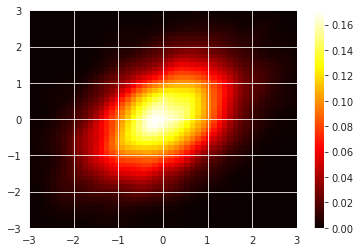

In [154]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kde

# load the dataset
# geyser = np.loadtxt("geyser.csv", delimiter=",", skiprows=1)
geyser = train_gan[1].values

# extract the columns
duration = geyser[:,0]
waiting = geyser[:,1]

# create a scatter plot
# plt.scatter(duration, waiting)
# plt.xlim(0.5, 6)
# plt.ylim(40, 100)

# create a 2D kernel density estimate
xmin, xmax, ymin, ymax = -3, 3, -3, 3
X, Y = np.mgrid[xmin:xmax:50j, ymin:ymax:50j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([duration, waiting])
kernel = kde.gaussian_kde(values)
f1 = np.reshape(kernel(positions).T, X.shape)

# create an image plot of the density estimate
plt.imshow(f1, origin='lower', extent=[xmin, xmax, ymin, ymax], aspect='auto', cmap='hot')
plt.colorbar()
plt.show()

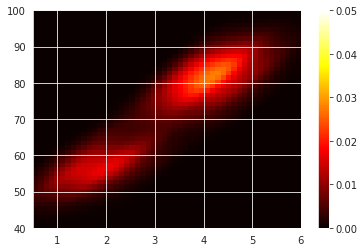

In [155]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kde

# load the dataset
# geyser = np.loadtxt("geyser.csv", delimiter=",", skiprows=1)
geyser = pd.read_csv('https://gist.githubusercontent.com/curran/4b59d1046d9e66f2787780ad51a1cd87/raw/9ec906b78a98cf300947a37b56cfe70d01183200/data.tsv', sep='\t')
geyser = geyser.values

# extract the columns
duration = geyser[:,0]
waiting = geyser[:,1]

# create a scatter plot
# plt.scatter(duration, waiting)
plt.xlim(0.5, 6)
plt.ylim(40, 100)

# create a 2D kernel density estimate
xmin, xmax, ymin, ymax = 0.5, 6, 40, 100
X, Y = np.mgrid[xmin:xmax:50j, ymin:ymax:50j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([duration, waiting])
kernel = kde.gaussian_kde(values)
f1 = np.reshape(kernel(positions).T, X.shape)

# create an image plot of the density estimate
plt.imshow(f1, cmap='hot', origin='lower', extent=[xmin, xmax, ymin, ymax], aspect='auto', vmin=0, vmax=0.05)
plt.colorbar()
plt.show()

NameError: ignored

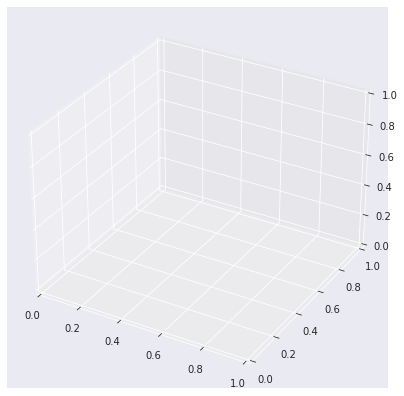

In [156]:
#https://towardsdatascience.com/simple-example-of-2d-density-plots-in-python-83b83b934f67
fig = plt.figure(figsize=(13, 7))
ax = plt.axes(projection='3d')
w = ax.plot_wireframe(x0, x1, f)
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('PDF')
ax.set_title('Wireframe plot of Gaussian 2D KDE');